In [2]:
import pandas as pd
import numpy as np

from pathlib import Path
import json
import cv2

import matplotlib.pyplot as plt
from infer import LitModule, get_embeddings, get_similarity, run_predict
from score import score_preds
%matplotlib inline

import torch
import pytorch_lightning as pl
import timm
import sklearn
import albumentations
print(torch.__version__)
print(pl.__version__)
print(timm.__version__)
print(sklearn.__version__)
print(albumentations.__version__)

1.11.0
1.6.0
0.5.4
1.0.2
1.1.0


In [3]:
######################
### Process Data25 ###
### Run it before train####################
### and pass the data path to config file.#
###########################################

# individual_id = []
# image_path = []
# image_size = []

# for path in Path("/data/hse/data/data_25/").glob("*/*g"):
#     iid = str(path.parent.name)
#     img = cv2.imread(str(path))
#     if img is not None:
#         individual_id.append(iid)
#         image_path.append(str(path))
#         image_size.append(img.shape[:2])

# df = pd.DataFrame({"individual_id": individual_id, "image_path": image_path, "image_size": image_size})
# df = df.sample(frac=1.).reset_index(drop=True)
# train = df.iloc[:-1000]
# val = df.iloc[-1000:].reset_index(drop=True)
# train.to_csv("/data/hse/data/train.csv", index=False)
# val.to_csv("/data/hse/data/val.csv", index=False)

# Dataset

## Train adn valid set

In [4]:
train = pd.read_csv("/data/hse/data/train.csv")
val = pd.read_csv("/data/hse/data/val.csv")

In [5]:
train.shape

(87572, 3)

In [6]:
val.shape

(1000, 3)

In [7]:
train_all = pd.concat([train, val], axis=0)

In [16]:
train_all.individual_id.nunique()

45390

In [9]:
train_all.individual_id.value_counts()

rl381795    64
rf417247    41
rf174651    19
rf397549    16
rl370077    16
            ..
rl316617     1
rf404212     1
rl327208     1
rl346076     1
rf159073     1
Name: individual_id, Length: 45390, dtype: int64

Text(0, 0.5, 'Frequency')

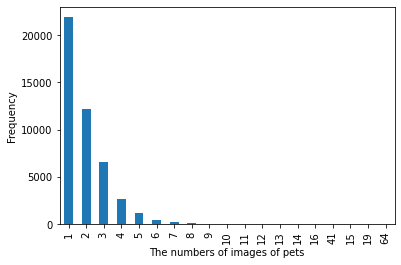

In [19]:
train_all.individual_id.value_counts().value_counts().plot(kind="bar")
plt.xlabel("The numbers of images of pets")
plt.ylabel("Frequency")

In [20]:
train.individual_id.nunique()

45138

In [21]:
val.individual_id.nunique()

990

In [22]:
len(set(val.individual_id) - set(train.individual_id))

252

In [ ]:
dev = pd.read_csv("/data/hse/")

# predict & eval example

In [4]:
model = "/data/hse/model/data25_convnext_small_ep10_img256/"
device = "cuda:0"
name = "convnext_256"
gt_path = "/data/hse/data/"
run_predict(name, model, device, "dev")
run_predict(name, model, device, "test")
score_preds("/data/hse/prediction/convnext_256/dev/preds.tsv", gt_path, ["dev"], None)

defaultdict(dict,
            {'hard_lost': {'nmatchable': 2131,
              'candR@1': 0.25293289535429375,
              'candR@3': 0.3693101830126701,
              'candR@10': 0.5194744251525105,
              'candR@30': 0.662599718442046,
              'candR@100': 0.7939934303144064,
              'candMRR': 0.34175706512585946,
              'hit1pred_nonm49%_P@top0.1': 0.4084507042253521,
              'hit1pred_nonm90%_P@top0.1': 0.0,
              'hit3pred_nonm49%_P@top0.1': 0.39906103286384975,
              'hit3pred_nonm90%_P@top0.1': 0.0,
              'hit10pred_nonm49%_P@top0.1': 0.45539906103286387,
              'hit10pred_nonm90%_P@top0.1': 0.009389671361502348},
             'hard_found': {'nmatchable': 1005,
              'candR@1': 0.33930348258706466,
              'candR@3': 0.47562189054726367,
              'candR@10': 0.6079601990049751,
              'candR@30': 0.7154228855721393,
              'candR@100': 0.8119402985074626,
              'candMRR': 0

# Analysis  Match

In [5]:
dev_pred = pd.read_table("/data/hse/prediction/convnext_256/dev/preds.tsv")
dev_gt = pd.read_csv("/data/hse/data/dev/registry.csv").rename({"query_name": "query", "answer_name": "gt"}, axis=1)
dev_pred = dev_pred.merge(dev_gt[['query', 'gt']], on='query', how='left')

In [19]:
dev_pred.head()

,query,answer,similarity,matched_1,matched_3,matched_10,gt
0,e1ba91d1c1,"44854e46c4,03b7cc20b4,fd07a59839,493fa14907,15...","1.0,0.305,0.269,0.265,0.248,0.247,0.242,0.229,...",1.0,0.762333,0.695778,44854e46c4
1,6be26c8fca,"9de7b1b827,2140f7b0a4,83963e48d5,d137bc4d12,61...","1.0,0.722,0.509,0.369,0.349,0.34,0.311,0.271,0...",1.0,0.871833,0.769211,NaN
2,5738659f9c,"e890c89a60,33fb39c0b3,7abb81b8cc,fea542bd6d,ab...","1.0,0.274,0.255,0.231,0.227,0.214,0.212,0.203,...",1.0,0.754833,0.684878,e890c89a60
3,9f1710a274,"242695059e,d08d4dd668,443d6e02df,4f55b89e54,9e...","1.0,1.0,0.352,0.306,0.281,0.267,0.227,0.213,0....",1.0,0.892000,0.765467,7090ab3dfd
4,7902984c62,"66897c3967,97c772fc0d,ad13d8d19b,da0a8ce2fa,30...","1.0,1.0,1.0,0.518,0.412,0.399,0.362,0.358,0.34...",1.0,1.000000,0.857467,36d5f5e3df


In [22]:
dev_pred['gt'].isnull().mean()

0.49236811568329913

In [23]:
def hit_k(df, k=100):
    answer = df.answer.values
    gt = df['gt'].fillna("Null").values
    
    hit = []
    
    for a, g in zip(answer, gt):
        a = a.split(",")
        if g in a[:k]:
            hit.append(1)
        else:
            hit.append(0)
    return hit

In [28]:
dev_pred['hit'] = hit_k(dev_pred)
dev_pred['hit_1'] = hit_k(dev_pred, 1)
dev_pred['hit_3'] = hit_k(dev_pred, 3)
dev_pred['hit_10'] = hit_k(dev_pred, 10)

In [29]:
dev_pred[dev_pred.hit == 1]

,query,answer,similarity,matched_1,matched_3,matched_10,gt,hit,hit_1,hit_3,hit_10
0,e1ba91d1c1,"44854e46c4,03b7cc20b4,fd07a59839,493fa14907,15...","1.0,0.305,0.269,0.265,0.248,0.247,0.242,0.229,...",1.000,0.762333,0.695778,44854e46c4,1,1,1,1
2,5738659f9c,"e890c89a60,33fb39c0b3,7abb81b8cc,fea542bd6d,ab...","1.0,0.274,0.255,0.231,0.227,0.214,0.212,0.203,...",1.000,0.754833,0.684878,e890c89a60,1,1,1,1
4,7902984c62,"66897c3967,97c772fc0d,ad13d8d19b,da0a8ce2fa,30...","1.0,1.0,1.0,0.518,0.412,0.399,0.362,0.358,0.34...",1.000,1.000000,0.857467,36d5f5e3df,1,0,0,0
5,cb280a0c57,"de18caf487,396ebb8efe,b03ca6ff7d,8b9705e269,5e...","1.0,0.288,0.27,0.243,0.227,0.22,0.21,0.206,0.2...",1.000,0.759667,0.688989,de18caf487,1,1,1,1
8,a6d62af1cb,"c4f89c549f,c4f89c549f,6be07040b7,6be07040b7,61...","1.0,0.697,0.339,0.312,0.273,0.263,0.257,0.257,...",1.000,0.839333,0.742611,c4f89c549f,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
11148,8a2beca3a6,"b5f7b25d65,783151865b,8c3a6adeba,e305826fef,ec...","0.231,0.206,0.205,0.196,0.191,0.188,0.182,0.18...",0.231,0.222500,0.215167,783151865b,1,0,1,1
11164,a7db130a5a,"78ecb0b05f,2354aab677,4d57d1c49b,f6c94a645c,73...","0.226,0.2,0.184,0.181,0.174,0.166,0.166,0.165,...",0.226,0.214667,0.206489,78ecb0b05f,1,1,1,1
11167,8cdd7c5dee,"d969d93a04,fc68159075,29179df3a1,db5cf8e0b6,37...","0.226,0.184,0.184,0.176,0.17,0.17,0.161,0.16,0...",0.226,0.212000,0.204133,37b76e4293,1,0,0,1
11169,6f07a32047,"5120e4e24b,c815eab24a,d7efe32b37,4267093b6a,4b...","0.225,0.216,0.211,0.19,0.189,0.187,0.187,0.176...",0.225,0.221167,0.212389,d7efe32b37,1,0,1,1


In [30]:
def extract_similarity(df):
    ss = df['similarity'].values
    ess = np.array([s.split(",") for s in ss]).astype(np.float32)
    return ess

In [35]:
hit1 = extract_similarity(dev_pred[dev_pred.hit_1 == 1])
non_hit1 = extract_similarity(dev_pred[dev_pred.hit_1 != 1])

In [41]:
hit1.std(axis=1).mean()

0.05992635

In [42]:
non_hit1.std(axis=1).mean()

0.04202711

In [45]:
((hit1[:, 0] - hit1[:, 1:].mean(axis=1)) / hit1.std(axis=1)).mean()

6.6616635

In [46]:
((non_hit1[:, 0] - non_hit1[:, 1:].mean(axis=1)) / non_hit1.std(axis=1)).mean()

4.1586556

In [47]:
hit1[:, 0].mean()

0.58371055

In [48]:
non_hit1[:, 0].mean()

0.3473713

In [49]:
hit1.mean()

0.17314388

In [50]:
non_hit1.mean()

0.16797028

In [52]:
dev_pred['first_score'] = dev_pred['similarity'].apply(lambda x: float(x.split(",")[0]))

In [54]:
dev_pred[(dev_pred.first_score > 0.99)].hit_1.mean()

0.3568904593639576

In [55]:
dev_pred[(dev_pred.first_score == 1)].hit_1.mean()

0.3670212765957447

In [56]:
dev_pred[(dev_pred.first_score == 1) & (dev_pred.hit_1 == 0)]

,query,answer,similarity,matched_1,matched_3,matched_10,gt,hit,hit_1,hit_3,hit_10,first_score
1,6be26c8fca,"9de7b1b827,2140f7b0a4,83963e48d5,d137bc4d12,61...","1.0,0.722,0.509,0.369,0.349,0.34,0.311,0.271,0...",1.0,0.871833,0.769211,NaN,0,0,0,0,1.0
3,9f1710a274,"242695059e,d08d4dd668,443d6e02df,4f55b89e54,9e...","1.0,1.0,0.352,0.306,0.281,0.267,0.227,0.213,0....",1.0,0.892000,0.765467,7090ab3dfd,0,0,0,0,1.0
4,7902984c62,"66897c3967,97c772fc0d,ad13d8d19b,da0a8ce2fa,30...","1.0,1.0,1.0,0.518,0.412,0.399,0.362,0.358,0.34...",1.0,1.000000,0.857467,36d5f5e3df,1,0,0,0,1.0
6,9ae25f3d03,"9de7b1b827,2140f7b0a4,83963e48d5,d137bc4d12,61...","1.0,0.722,0.509,0.369,0.349,0.34,0.311,0.271,0...",1.0,0.871833,0.769211,fce3738dc9,0,0,0,0,1.0
7,5a5dc23a15,"23b164e8fb,303cfe4c82,1fba8acf8c,e76e80c62a,ad...","1.0,0.525,0.386,0.366,0.362,0.362,0.362,0.358,...",1.0,0.818500,0.753333,NaN,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7827,e1cc30c0ee,"3e6e0e84d9,9806e50201,092c6e5476,41865af819,41...","1.0,0.724,0.528,0.495,0.457,0.45,0.413,0.381,0...",1.0,0.875333,0.798278,9806e50201,1,0,1,1,1.0
7834,9d5db1d873,"b2da4c4d81,b64101165d,3cc1803090,21ac71a89f,34...","1.0,1.0,0.895,0.431,0.36,0.315,0.295,0.292,0.2...",1.0,0.982500,0.833200,3cc1803090,1,0,1,1,1.0
7838,e0f0c04e5e,"21ac71a89f,9d756324db,3de35debf4,3d87303c2d,f1...","1.0,0.566,0.56,0.529,0.471,0.468,0.457,0.44,0....",1.0,0.854333,0.797011,NaN,0,0,0,0,1.0
7839,8c07647cc8,"44602fc2ec,64edeb52f7,636d89803f,476a1c55b4,48...","1.0,0.603,0.412,0.399,0.383,0.348,0.347,0.347,...",1.0,0.835833,0.762978,476a1c55b4,1,0,0,1,1.0
